In [1]:
import re
import spacy
import pandas as pd
import networkx as nx
from tqdm import tqdm
from spacy import displacy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pyvis.network import Network
from transliterate import translit
from utils import *

spacy.prefer_gpu()
tqdm.pandas()

STOPWORDS = set(stopwords.words('english'))

NER = spacy.load("en_core_web_lg")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/guillaumefranzonidarnois/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykern

In [2]:
messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
messages['messageDateTime'] = messages['messageDate'].astype('datetime64[ns]')
messages['year_month'] = messages['messageDateTime'].dt.strftime('%Y_%m')
messages['chat'] = messages.chat.progress_apply(lambda x: x.replace('https://t.me/', ''))
messages = compute_popularity(messages)

/var/folders/fb/v6scng3j5lbcmnb3mjn82zhr0000gn/T/ipykernel_46254/2997431438.py:1: DtypeWarning: Columns (22,25,26,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
100%|██████████| 152345/152345 [00:00<00:00, 1846921.40it/s]


In [214]:
# chat = messages[messages.chat == 'financialtimes']
chat = messages

In [215]:
docs = []
for time_frame in tqdm(list(chat.year_month.unique())):
    top_daily_messages = list(chat[chat.year_month == time_frame].sort_values('popularity_score',ascending = False).head(1000).messageText.values)
    docs.append({
        'messages': top_daily_messages,
        'document': '\n'.join(top_daily_messages),
        'frame': time_frame
    })

100%|██████████| 64/64 [00:00<00:00, 120.01it/s]


In [216]:
from itertools import combinations
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" #emotions
                           u"\U0001F300-\U0001F5FF" #sumbols and pictographs
                           u"\U0001F680-\U0001F6FF" #transport and map symbols
                           u"\U0001F1E0-\U0001F1FF" #flags
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 

                           "]+",flags = re.UNICODE)

dcs = []
bcs = []
ccs = []

for doc in tqdm(docs):
    edge_list = []
    entities = ner_message(doc['document'])
    for sentence_entities in entities:
        if len(sentence_entities)>1:
            edge_list.extend(combinations(sentence_entities, 2))
    
    edges = pd.DataFrame(edge_list, columns=['source', 'target'])

    edges.source = edges.source.apply(lambda x: x.replace('\'s', ''))
    edges.target = edges.target.apply(lambda x: x.replace('\'s', ''))

    edges.source = edges.source.apply(lambda x: emoji_pattern.sub(r'', x))
    edges.target = edges.target.apply(lambda x: emoji_pattern.sub(r'', x))

    edges.source = edges.source.apply(lambda x: translit(x, 'ru', reversed=True))
    edges.target = edges.target.apply(lambda x: translit(x, 'ru', reversed=True))

    count_series = edges.groupby(['source', 'target']).size()
    edges = count_series.to_frame(name = 'value').reset_index()
    edges = edges[(edges['source'].str.len() > 1) & (edges['target'].str.len() > 1)]

    G = nx.from_pandas_edgelist(
        edges,
        source='source',
        target='target',
        edge_attr='value',
        create_using=nx.Graph()
    )

    dcs.append(nx.degree_centrality(G))
    bcs.append(nx.betweenness_centrality(G))
    ccs.append(nx.closeness_centrality(G))

degree_evol_df = pd.DataFrame.from_records(dcs)
betweenness_evol_df = pd.DataFrame.from_records(bcs)
closeness_evol_df = pd.DataFrame.from_records(ccs)

100%|██████████| 64/64 [09:21<00:00,  8.78s/it]


<Axes: >

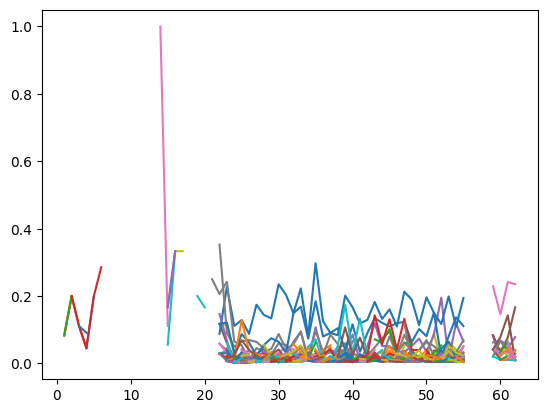

In [217]:
degree_evol_df.plot(legend=False)

<Axes: >

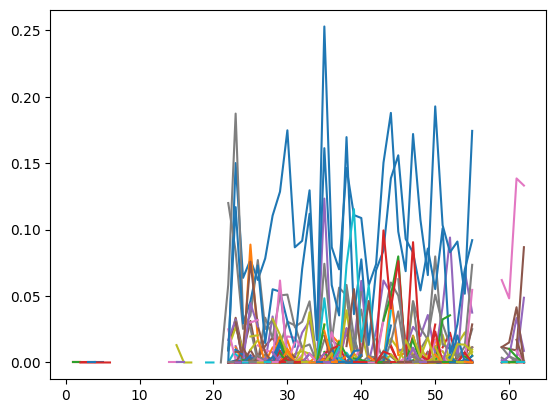

In [218]:
betweenness_evol_df.plot(legend=False)

<Axes: >

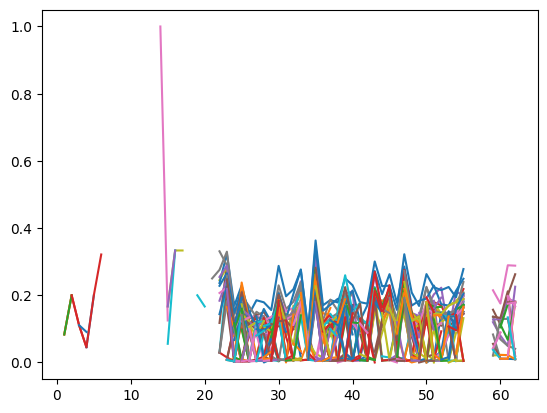

In [219]:
closeness_evol_df.plot(legend=False)

In [220]:
degree_evol_df

,Andres Schipani,Andrés Manuel López Obrador,Jair Bolsonaro,Gideon Rachman,Francis Fukuyama,Jude Webber,Miles Johnson,Daniel Dombey,Rishi Sunak,Matt Hancock,...,Sergei Loznitsa,Serhiy Semenchenko,Taras Berezovets,Timothy Ash,Katya Gorchinskaya,Tymoshenko,Vladyslav Manger,Yevgeny Kravtsov,Luhansk Oblasts,Oleh Bakhmatyuk
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.25,0.25,0.083333,0.083333,0.25,0.083333,0.083333,0.166667,0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.045455,NaN,NaN,NaN,NaN,0.090909,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,0.009804,NaN,NaN,NaN,NaN,NaN,...,0.009804,0.009804,0.009804,0.009804,0.009804,0.019608,0.009804,0.009804,0.009804,0.009804
